In [265]:
import spacy
import asent
import textdescriptives
import empath
import tqdm
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import decomposition, discriminant_analysis 
from matplotlib import pyplot as plt, lines
plt.style.use("minimal")

# HTML_cleaner = re.compile(r"<[^>]+>|\[Erowid Note:([\s\S]*)\]|\n|\r|<br>")

colormap = dict(
    DMT = "C0",
    LSD = "C1",
    Psilocybin = "C2",
    MDMA = "C3",
)

colormap = {
    "Ibogaine"      : "C7",
    "Salvinorin A"  : "C6",
    "Ketamine"      : "C5",
    "5-MeO-DMT"     : "C4",
    "DMT"           : "C3",
    "LSD"           : "C2",
    "Psilocybin"    : "C1",
    "MDMA"          : "C0",
}

In [273]:
def load_data():
    global database
    database = pd.read_parquet("database.parquet")
    # database["substance"] = pd.Categorical(database["substance"], ("DMT", "LSD", "Psilocybin", "MDMA"))
    database["substance"] = pd.Categorical(database["substance"], colormap.keys())
    database["substance_ID"] = database["substance"].cat.codes
    # database["time_of_experience"] = pd.to_datetime(database["time_of_experience"].str.split("-").str[0], format = "%Y", errors = "coerce")
    database["time_of_submission"] = pd.to_datetime(database["time_of_submission"], format = "%b %d, %Y", errors = "coerce")
    database["age_at_experience"] = database["age_at_experience"].replace({"Not Given": pd.NA})
    database["gender"] = database["gender"].replace({"not specified": pd.NA})
    database["content"] = database["content"].fillna("").str.replace(r"<[^>]+>|\[Erowid Note:([\s\S]*)\]|\n|\r|<br>", " ", regex=True)

load_data()
database

,experience_ID,author,substance,content,time_of_experience,time_of_submission,age_at_experience,gender,substance_ID
0,109031,Lightshowoff,MDMA,"I am writing this report in July 2016, about e...",2008,2016-08-18,27,male,7
1,117799,Soma91,MDMA,New Year's Eve 2024: First Time Rolling at a R...,2024,2024-01-10,32,female,7
2,115298,fortymore,MDMA,"[Trigger warning for frank, but hopefully empo...",2021,2021-04-02,30,male,7
3,112960,Anatoli Smorin,MDMA,. These are far faster than my typical depa...,2011,2019-03-16,21,male,7
4,109469,Pyrojax,MDMA,I wish to share my own story with MDMA. This i...,2011,2017-07-24,19,male,7
...,...,...,...,...,...,...,...,...,...
5031,1967,Anonymous,Ketamine,Ketamine was a pretty unique experience. Thoug...,,NaT,Not Given,<NA>,2
5032,135,Doobie,Ketamine,After finding out from various resources on Ke...,2000,NaT,Not Given,<NA>,2
5033,113191,DepressedLoser123,Ketamine,[Reported Dose: 150 mg] I am 24 years old...,2019,NaT,24,male,2
5034,41302,Pevans,Salvia A,"My friends and I are marijuana smokers, we are...",2005,NaT,Not Given,male,1


In [274]:
print(len(database), "reports")
print(pd.DataFrame(database["substance"].value_counts()))
print(pd.DataFrame(database["gender"].value_counts()))

4718 reports
            substance
LSD              1177
Psilocybin       1103
DMT               630
Salvia A          609
MDMA              569
Ketamine          344
5-MeO-DMT         257
Ibogaine           29
        gender
male      3568
female     839


In [275]:
empath_lexicon = empath.Empath()
print(", ".join(empath_lexicon.cats.keys()))

@spacy.language.Language.component("empath_client")
def empath_client(doc):
    if not spacy.tokens.Doc.has_extension("empath"):
        spacy.tokens.Doc.set_extension("empath", default=None)
    doc._.empath = empath_lexicon.analyze(doc.text, normalize=True)
    return doc

help, office, dance, money, wedding, domestic_work, sleep, medical_emergency, cold, hate, cheerfulness, aggression, occupation, envy, anticipation, family, vacation, crime, attractive, masculine, prison, health, pride, dispute, nervousness, government, weakness, horror, swearing_terms, leisure, suffering, royalty, wealthy, tourism, furniture, school, magic, beach, journalism, morning, banking, social_media, exercise, night, kill, blue_collar_job, art, ridicule, play, computer, college, optimism, stealing, real_estate, home, divine, sexual, fear, irritability, superhero, business, driving, pet, childish, cooking, exasperation, religion, hipster, internet, surprise, reading, worship, leader, independence, movement, body, noise, eating, medieval, zest, confusion, water, sports, death, healing, legend, heroic, celebration, restaurant, violence, programming, dominant_heirarchical, military, neglect, swimming, exotic, love, hiking, communication, hearing, order, sympathy, hygiene, weather, a

In [276]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("sentencizer")
nlp.add_pipe("asent_en_v1")
nlp.add_pipe("textdescriptives/all")
nlp.add_pipe("empath_client")
# contextualSpellCheck
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'sentencizer',
 'asent_en_v1',
 'textdescriptives/coherence',
 'textdescriptives/dependency_distance',
 'textdescriptives/descriptive_stats',
 'textdescriptives/pos_proportions',
 'textdescriptives/quality',
 'textdescriptives/readability',
 'textdescriptives/information_theory',
 'textdescriptives/all',
 'empath_client']

In [345]:
# load_data()
# database = database.sample(10)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     docs = list(tqdm.tqdm(nlp.pipe(database["content"]), total = len(database)))

    # database["vector"] = [doc.vector for doc in docs]
    # database[["sentiment", "sentiment_neg", "sentiment_neu", "sentiment_pos"]] = [(doc._.polarity.compound, doc._.polarity.negative, doc._.polarity.neutral, doc._.polarity.positive) for doc in docs]
    # database[list(empath_lexicon.cats.keys())] = [[doc._.empath[cat] for cat in empath_lexicon.cats.keys()] for doc in docs]

# database.to_parquet("database_processed.parquet")

In [ ]:
# database = pd.read_parquet("database_processed.parquet")
# database

In [ ]:
# dimension = "sentiment"
# dimension = "love"
# dimension = "fear"

# sns.violinplot(
#     database, 
#     x = "substance",
#     y = dimension, 
#     hue = "substance",
#     density_norm = "width",
#     saturation = 1,
#     linewidth = 0.6,
#     inner = "box",
# )
# for violin in plt.gca().collections:
#     violin.set_alpha(0.8)
#     violin.set_linewidth(0)

# plt.axhline(y = 0, linewidth = 1, color = "black", alpha = 0.4, zorder = -1)

# plt.xlabel("")
# plt.ylabel("")
# plt.title("Erowid Trip Reports\nCompound Sentiment")
# plt.margins(x=0.1, y = 0.15)
# plt.show()

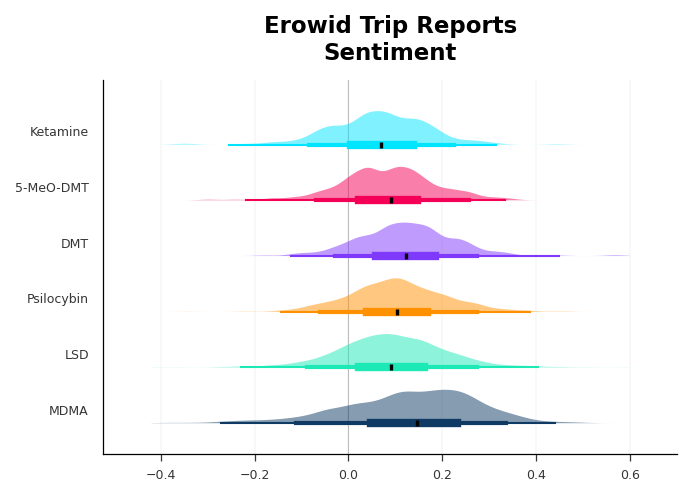

In [336]:
def compare_substances(dimension, substance_subset = None):
    data = database[database["substance"].isin(substance_subset)] if substance_subset else database

    data_range = data[dimension].agg(("min", "max"))
    x_range = np.linspace(*data_range, num = 1000)

    for substance_idx, (substance, subset) in enumerate(data.groupby("substance", observed = True)[dimension]):
        substance_idx -= 0.25
        estimation = stats.gaussian_kde(subset, bw_method = 0.2)(x_range)
        plt.fill_between(
            x_range, 
            substance_idx,
            substance_idx + 0.6 * (estimation / estimation.max()),
            color = colormap[substance],
            label = substance,
            alpha = 0.5,
            edgecolor = "none",
        )

        for interval, linewidth in zip((0.5, 0.9, 0.99), (4, 2, 1)):
            plt.plot(
                np.quantile(subset, ((1 - interval) / 2, 1 - (1 - interval) / 2)),
                [substance_idx, substance_idx],
                linewidth = linewidth,
                color = colormap[substance],
                # color = "black",
            )
        plt.scatter(
            [np.median(subset)],
            [substance_idx],
            color = "black",
            marker = "|",
            s = 10,
            zorder = 2,
        )

    plt.axvline(x = 0, linewidth = 0.5, color = "grey", alpha = 0.5, zorder = -1)

    plt.yticks(range(len(data["substance"].unique())), data["substance"].unique())
    plt.tick_params(left = False)
    plt.margins(x=0.1, y = 0.1)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(f"Erowid Trip Reports\n{dimension.capitalize()}")
    plt.grid(True, axis = "x", which = "both")
    plt.grid(False, axis = "y")

    plt.show()

# compare_substances("fear")
# compare_substances("love")
# compare_substances("sentiment")
compare_substances("sentiment", substance_subset=("MDMA", "Psilocybin", "LSD", "DMT", "5-MeO-DMT", "Ketamine"))

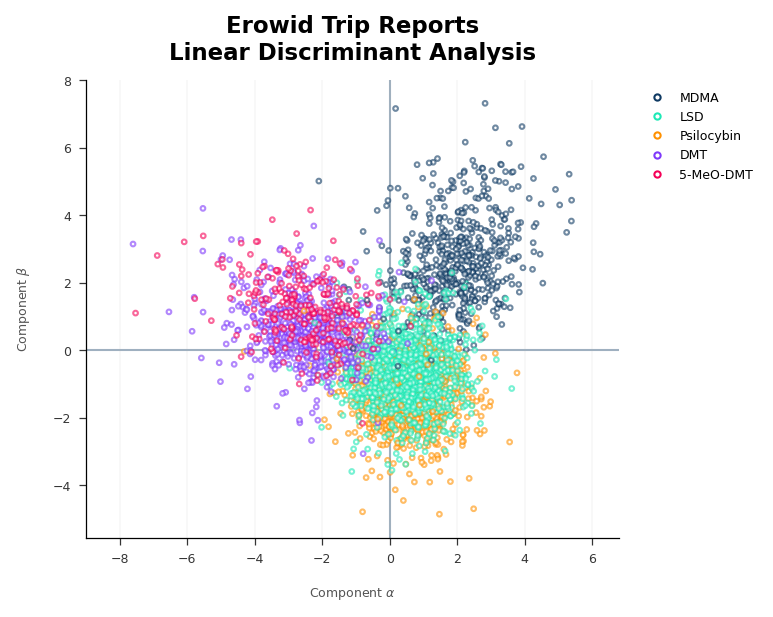

In [314]:
def decompose(n_components = 2, method = "LDA", substance_subset = None):
    data = database[database["substance"].isin(substance_subset)] if substance_subset else database
    data = data.sample(frac = 1, axis = 1)

    decomposer = dict(
        LDA = discriminant_analysis.LinearDiscriminantAnalysis, # https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html
        PCA = decomposition.PCA,
        ICA = decomposition.FastICA,
    )[method]
    
    if method == "LDA": # supervised: needs class labels
        data[[f"comp_{idx}" for idx in range(n_components)]] = decomposer(n_components=n_components).fit_transform([vec for vec in data["vector"]], data["substance"])
    else:
        data[[f"comp_{idx}" for idx in range(n_components)]] = decomposer(n_components=n_components).fit_transform([vec for vec in data["vector"]])

    fig, ax = plt.subplots(figsize=(5, 4))

    ax.scatter(
        data["comp_0"], 
        data["comp_1"], 
        color = "white",
        edgecolor = data["substance"].map(colormap),
        s = 5,
        alpha = 0.6,
        clip_on = False,
    )

    ax.legend(
        handles = [lines.Line2D([], [], marker="o", color="w", label=substance, markeredgecolor=colormap.get(substance), markersize=3) for substance in data["substance"].unique()],
        loc = "upper center", 
        bbox_to_anchor = (1.15, 1), 
    )

    ax.axvline(x = 0, linewidth = 1, alpha = 0.4, zorder = -1)
    ax.axhline(y = 0, linewidth = 1, alpha = 0.4, zorder = -1)

    ax.set_xlabel(r"Component $\alpha$")
    ax.set_ylabel(r"Component $\beta$")
    ax.set_title("Erowid Trip Reports\nLinear Discriminant Analysis")

    ax.grid(which="both")
    ax.margins(x = 0.1, y = 0.1)

    # ax.set_xlim(-4, 4)
    # ax.set_ylim(-4, 4)
    ax.axis("equal")
    ax.set_aspect("equal", "datalim")

    plt.show()

# decompose()
# decompose(substance_subset=("MDMA", "Psilocybin", "LSD", "DMT"))
decompose(substance_subset=("MDMA", "Psilocybin", "LSD", "DMT", "5-MeO-DMT"))
# decompose(substance_subset=("MDMA", "Psilocybin", "LSD", "DMT", "5-MeO-DMT", "Ketamine"))

In [342]:
alternative_names = [
    "DMT",
    "N,N-DMT",
    "Dmitry",
    "Glory",
    "Spirit Molecule",
    "5-MeO-DMT",
    "Toad",
    "Jaguar",
    "Soma",
    "God Molecule",
    "LSD",
    "LSD-25",
    "Lucy",
    "L",
    "Acid",
    "Cid",
    "Tabs",
    "Blotter",
    "Psilocybin",
    "Psilocin",
    "Mushrooms",
    "Magic mushrooms",
    "Shrooms",
    "MDMA",
    "Molly",
    "Mandy",
    "Emma",
    "MD",
    "Ecstasy",
    "E",
    "X",
    "XTC",
    "Ketamine",
    "K",
    "Kitty",
    "Special K",
    "Tranquilizer",
    "Vitamin K",
    "Purple",
    "Jet",
    "Salvianorin A",
    "Salvia",
    "Salvia Divinorum",
    "Sally",
    "Ibogaine",
    "Iboga",
    "Endabuse"
]
a = nlp("I took DMT (also called The Spirit Molecule). It was crazy!")
a
[token for token in a]
[token.is_stop for token in a]

[True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False]

In [344]:
spacy.lang.en.stop_words.STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [294]:
docs[0].vector is database.iloc[0]["vector"]

True